In [105]:
import polars as pl
from matplotlib import pyplot as plt
import numpy as np
import json

In [106]:
ground_truth = pl.read_csv('../experiments/experiment60/result.csv')
# ground_truth = pl.read_csv('../data/new_pws_estimate.csv')
mlpws_result = pl.read_csv('../experiments/experiment58/result.csv')
# mlpws_result = pl.read_csv('../data/new_mlpws_estimate.csv')
doe_result = pl.read_csv('../experiments/experiment41/result.csv')
infonce_result = pl.read_csv('../experiments/experiment42/result.csv')

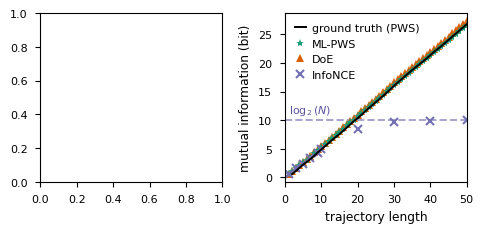

In [107]:
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update(
    {
        "font.size": 8,
        "lines.markersize": 6,
        "lines.markeredgewidth": 0.0,
        "legend.handlelength": 1.0,
        "legend.handletextpad": 0.5,
    }
)

width = 340 / 72
height = 160 / 72

colors = plt.get_cmap("Dark2").colors

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(width, height), constrained_layout=True
)
ax2.set_prop_cycle(plt.cycler(color=colors))
ax2.plot(
    ground_truth["step"] + 1,
    ground_truth["mean"] / np.log(2),
    label="ground truth (PWS)",
    color="black",
    zorder=3,
)
ax2.plot(
    mlpws_result["step"],
    mlpws_result["mean"] / np.log(2),
    "*",
    label="ML-PWS",
    zorder=2,
)
# ax.plot(json_data['Time'], json_data['MutualInformation'] / np.log(2), label="ground truth (PWS)", color='black')
ax2.plot(
    doe_result["step"],
    doe_result["mean"] / np.log(2),
    "^",
    label="DoE",
    zorder=1,
)
#
ax2.plot(
    infonce_result["step"],
    infonce_result["mean"] / np.log(2),
    "x",
    markeredgewidth=1.5,
    label="InfoNCE",
)
ax2.axhline(np.log2(1000), color="#A6A3CE", linestyle="--", zorder=0)
ax2.text(
    1,
    np.log2(1000) + 0.5,
    "$\\log_2(N)$",
    horizontalalignment="left",
    verticalalignment="bottom",
    color="#5B55A0",
)
ax2.legend(frameon=False)
ax2.set_xlabel("trajectory length")
ax2.set_ylabel("mutual information (bit)")
ax2.set_xlim(0, 50)

fig

# Gain Sweep

In [108]:
from glob import glob

result_paths = glob('../experiments/experiments/gain_sweep01/*')

data = []
for p in result_paths:
    with open(p + '/parameters.json', "r") as file:
        params = json.load(file)
    result_path = params['result_path']
    result = pl.read_csv(result_path)
    data.append({
        "gain": params['gain'],
        'estimator': params['estimator'],
        'MI': result['mean'][-1],
        'sample_size': params['num_pairs'],
        'result_path': params['result_path'],
    })
data = pl.DataFrame(data)
data

gain,estimator,MI,sample_size,result_path
f64,str,f64,i64,str
0.2934266,"""PWS""",3.5940957,1000,"""/data/clusterusers/reinhardt/c…"
0.050528,"""PWS""",0.107989,1000,"""/data/clusterusers/reinhardt/c…"
0.025,"""PWS""",0.022116,1000,"""/data/clusterusers/reinhardt/c…"
0.2063979,"""PWS""",1.889263,1000,"""/data/clusterusers/reinhardt/c…"
0.145181,"""PWS""",0.956492,1000,"""/data/clusterusers/reinhardt/c…"
…,…,…,…,…
20.0,"""Gaussian""",21.164751,1000,"""/data/clusterusers/reinhardt/c…"
14.068111,"""Gaussian""",20.841742,100000,"""/data/clusterusers/reinhardt/c…"
6.960611,"""Gaussian""",22.927381,100000,"""/data/clusterusers/reinhardt/c…"


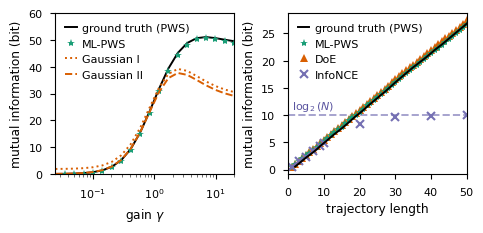

In [109]:
ground_truth = data.filter(pl.col("estimator") == "PWS").sort("gain")
ml_pws = data.filter(pl.col("estimator") == "ML-PWS").sort("gain")
gaussian1 = data.filter(
    (pl.col("estimator") == "Gaussian") & (pl.col("sample_size") == 1000)
).sort("gain")
gaussian2 = data.filter(
    (pl.col("estimator") == "Gaussian") & (pl.col("sample_size") == 100000)
).sort("gain")

labels = ["ground truth (PWS)", "ML-PWS", "Gaussian I", "Gaussian II"]
colors = plt.get_cmap("Dark2").colors
formats = ["-", "*", ":", "--"]

ax1.set_xscale("log")
for label, df, fmt, c in zip(
    labels,
    [ground_truth, ml_pws, gaussian1, gaussian2],
    formats,
    ["black", colors[0], colors[1], colors[1]],
):
    ax1.plot(df["gain"], df["MI"] / np.log(2), fmt, color=c, label=label)
ax1.legend(frameon=False)
ax1.set_ylabel("mutual information (bit)")
ax1.set_xlabel("gain $\\gamma$")
ax1.set_xlim(0.025, 20)
ax1.set_ylim(0, 60)

fig.savefig('../reports/figures/ml_pws_comparisons.pdf')
fig

# Testing the statistical properties of input data

In [ ]:
import torch
import numpy as np
from statsmodels.tsa.stattools import levinson_durbin
import json

EXP_NUM = 43

data = torch.load(f'../experiments/experiment{EXP_NUM}/input_data.pth')
with open(f'../experiments/experiment{EXP_NUM}/parameters.json', 'r') as file:
    params = json.load(file)
s = data['val_s']
x = data['val_x']
params

{'run_info': {'start_time': '2025-08-15T15:20:20.721355+00:00',
  'hostname': 'cluster-new.hollandia.amolf.nl'},
 'ar_coeffs': [0.5, -0.3, 0.2],
 'ar_std': 1.0,
 'gain': 1.0,
 'decay': 0.2,
 'output_noise': 0.2,
 'output_directory': '/data/clusterusers/reinhardt/containerhome/ml-pws/experiments/experiment43',
 'result_path': '/data/clusterusers/reinhardt/containerhome/ml-pws/experiments/experiment43/result.csv',
 'forward_epochs': 500,
 'backward_epochs': 100,
 'hidden_features': 64,
 'num_pairs': 1000,
 'length': 50,
 'seed': 0,
 'estimator': 'ML-PWS'}

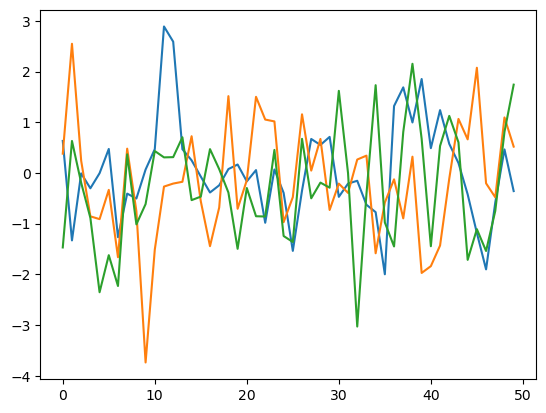

In [ ]:
plt.plot(s[:3].T)

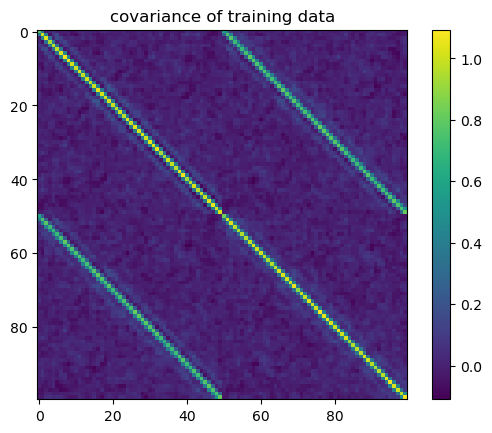

In [ ]:
plt.imshow(np.cov(np.concat([s / s.std(), x / x.std()], axis=1).T))
plt.title('covariance of training data')
plt.colorbar()

Text(0.5, 0, 'lag')

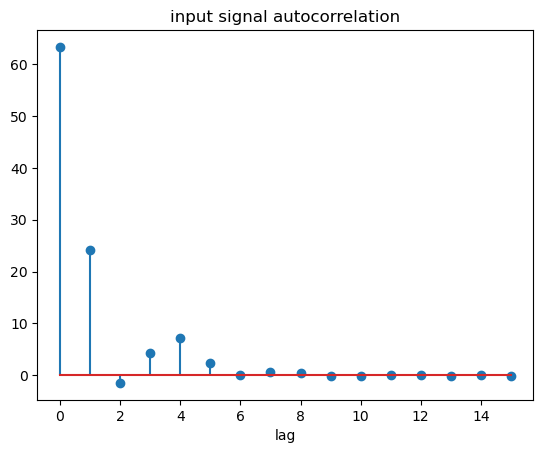

In [ ]:
lags = np.arange(-s.shape[-1]+1, s.shape[-1])
max_lags = 15
acov = np.mean(np.stack([np.correlate(s, s, mode='full') for s in s]), axis=0)
pos = np.logical_and(lags >= 0, lags <= max_lags)
plt.stem(lags[pos], acov[pos])
plt.title('input signal autocorrelation')
plt.xlabel('lag')

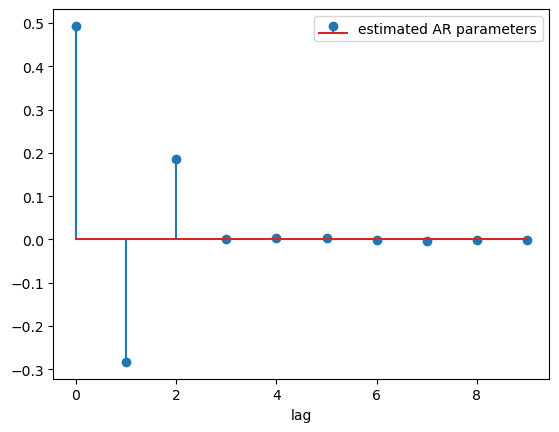

In [ ]:
sigma_v, arcoefs, pacf, _, _ = levinson_durbin(acov[pos], isacov=True)
plt.stem(arcoefs, label='estimated AR parameters')
# plt.stem(params['ar_coeffs'], markerfmt='green', label='true AR parameters')
plt.xlabel('lag')
plt.legend()

<BarContainer object of 2 artists>

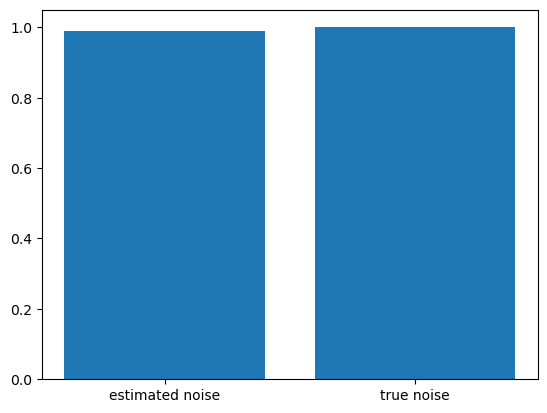

In [ ]:
conv_params = np.insert(-np.array(params['ar_coeffs']), 0, 1)
residuals = np.zeros_like(s)
for i in range(residuals.shape[0]):
    residuals[i, :] = np.convolve(s[i], conv_params, mode='same')
plt.bar(['estimated noise', 'true noise'], [np.std(residuals), params['ar_std']])